In [72]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 导入数据

In [96]:
def get_data_excel(path):
    # data = pd.read_excel(path)
    data = pd.DataFrame(pd.read_excel('D:\OneDrive\Projects\Coding\Dachuang_20232024/data/bjtotal.xlsx'))
    data.dropna(inplace=True)
    # data = data[['time', 'price']]
    data = data.set_index('time', drop=True)
    # print(data_temp)
    
    data.index = pd.to_datetime(data.index)
    # 假设 df 是您的 DataFrame，其中日期时间索引为 'datetime_index'
    df = data.sort_index(ascending=True)
    
    df.dropna(inplace=True)
    
    select_columns = ['count', 'temp', 'open94', 'open4','price']
    
    df = df[select_columns]
    print(df.head(5))
    # 打印排序后的 DataFrame
    return df

df = get_data_excel('D')

            count   temp   open94     open4  price
time                                              
2020-01-06    487  0.167  1420.98  2409.645   73.1
2020-01-07    400  0.750  1468.13  2422.662   76.2
2020-01-08    300  0.458  1469.20  2438.344   80.1
2020-01-09    350 -1.208  1476.34  2427.006   84.5
2020-02-18      1  2.292  1602.77  2407.864   84.5


# 数据预处理

In [97]:
from sklearn.ensemble import IsolationForest

def iso_tree(df):
    iso = IsolationForest(random_state=1, contamination='auto')
    preds = iso.fit_predict(df.values)
    df['cluster'] = preds
    print(df['cluster'].value_counts().sort_values(ascending=False))
    df = df[df['cluster'] != -1].drop(columns=['cluster'])
    print("处理后的数据框形状：", df.shape)
    return df

df = iso_tree(df)

cluster
 1    597
-1    148
Name: count, dtype: int64
处理后的数据框形状： (597, 5)


In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# 输入序列(t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# 预测序列(t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# 把所有放在一起
	agg = concat(cols, axis=1)
	agg.columns = names
	# 删除空值行
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def prepare_data(df):
    values = df.values
    values = values.astype('float32')
    reframed = series_to_supervised(values, 30, 1)
    reframed.drop(reframed.columns[-5:-1], axis=1, inplace=True)
    print(reframed.head(3))
    
    scaler_s = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    
    values = reframed.values
    values = scaler_s.fit_transform(values)
    
    n_train_hours = int(len(values)*0.8)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    
    # train = scaler_s.fit_transform(train)
    # test = scaler_s.transform(test)
    train_x, train_y = train[:, :-1], train[:, -1]
    test_x, test_y = test[:, :-1], test[:, -1]
    
    train_x = train_x.reshape(train_x.shape[0], 1 , train_x.shape[1])
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])
    
    print(train_x.shape, train_y.shape)
    return train_x, train_y, test_x, test_y
    
    
train_x,train_y,test_x,test_y = prepare_data(df)


    var1(t-30)  var2(t-30)   var3(t-30)   var4(t-30)  var5(t-30)  var1(t-29)  \
30       111.0      16.625  1433.550049  2316.988037   86.169998      4680.0   
31      4680.0      20.667  1470.520020  2387.910889   74.339996       109.0   
32       109.0      21.458  1473.469971  2385.460938   88.000000       307.0   

    var2(t-29)   var3(t-29)   var4(t-29)  var5(t-29)  ...  var2(t-2)  \
30      20.667  1470.520020  2387.910889   74.339996  ...     26.375   
31      21.458  1473.469971  2385.460938   88.000000  ...     27.875   
32      27.875  1499.760010  2424.849121   89.099998  ...     26.667   

      var3(t-2)    var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)    var3(t-1)  \
30  1976.260010  2886.537109  84.870003      100.0     27.875  1956.520020   
31  1956.520020  2875.177002  94.000000     5175.0     26.667  1812.790039   
32  1812.790039  2678.870117  94.000000     4005.0     28.000  1864.420044   

      var4(t-1)  var5(t-1)    var5(t)  
30  2875.177002  94.000000  94.000000

In [ ]:
from keras import regularizers
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, BatchNormalization, Dropout
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

class LSTMmodel:
    def __init__(self, input_shape, units=50):
        self.input_shape = input_shape
        self.units = units
        self.model = self.build_model(input_shape)
    
    def build_model(self, input_shape, units=100):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=input_shape, return_sequences=True))
        model.add(Dropout(0.1))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(32))
        # model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # 添加L2正则化
        model.add(Dropout(0.2))  # 添加Dropout层，丢弃率为0.2
        model.add(Dense(units=1))  # 输出层只有一个神经元，用于预测价格
        model.compile(loss='mean_squared_error', optimizer='adam')  # 使用均方误差作为损失函数
        return model
    
    def train(self, train_x, train_y, epochs=50, batch_size=32, validation_data=None):
        # callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        self.model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        # , callbacks=callbacks)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def showmodel(self):
        print(self.model.summary())

LSTM_model = LSTMmodel(input_shape=train_x.shape[1:], units=100) 
LSTM_model.train(train_x, train_y, epochs=300, batch_size=30, validation_data=(test_x, test_y))
LSTM_model.showmodel()


# 自动调优与模型重训练

In [114]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), 
                   input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(hp.Choice('l2_reg', values=[0.001, 0.01, 0.1]))))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='mse',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(train_x, train_y, epochs=10, validation_data=(test_x, test_y))

# 获取最优模型
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)


Trial 100 Complete [00h 00m 01s]

Best mse So Far: 0.3831353187561035
Total elapsed time: 00h 32m 46s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
416               |416               |units
0                 |0                 |dropout_rate
256               |288               |dense_units
0.01              |0.01              |l2_reg
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0019              |None              |tuner/trial_id


Traceback (most recent call last):
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = se

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "D:\Program Files\anaconda\envs\TensorflowCPU\lib\site-packages\tensorflow\python\training\saving\saveable_object_util.py", line 135, in restore
    raise ValueError(
ValueError: Received incompatible tensor with shape (450, 1664) when attempting to restore variable with shape (150, 1664) and name layer_with_weights-0/cell/kernel/.ATTRIBUTES/VARIABLE_VALUE.


In [115]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))


Epoch 1/100
15/15 [==============================] - 3s 55ms/step - loss: 3.6772 - mse: 0.6606 - val_loss: 3.1667 - val_mse: 0.6364
Epoch 2/100
15/15 [==============================] - 1s 33ms/step - loss: 2.7364 - mse: 0.5051 - val_loss: 2.5496 - val_mse: 0.6693
Epoch 3/100
15/15 [==============================] - 0s 23ms/step - loss: 2.0474 - mse: 0.3944 - val_loss: 2.0031 - val_mse: 0.6147
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 1.5716 - mse: 0.3546 - val_loss: 1.7096 - val_mse: 0.6892
Epoch 5/100
15/15 [==============================] - 0s 29ms/step - loss: 1.2182 - mse: 0.3226 - val_loss: 1.4223 - val_mse: 0.6667
Epoch 6/100
15/15 [==============================] - 0s 18ms/step - loss: 0.9543 - mse: 0.2863 - val_loss: 1.4375 - val_mse: 0.8688
Epoch 7/100
15/15 [==============================] - 0s 30ms/step - loss: 0.7909 - mse: 0.2864 - val_loss: 1.1166 - val_mse: 0.6848
Epoch 8/100
15/15 [==============================] - 0s 21ms/step - loss: 0.

# 结果输出

15/15 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.992
The R2 score on the Test set is:	-0.152
4/4 [==============================] - 0s 3ms/step


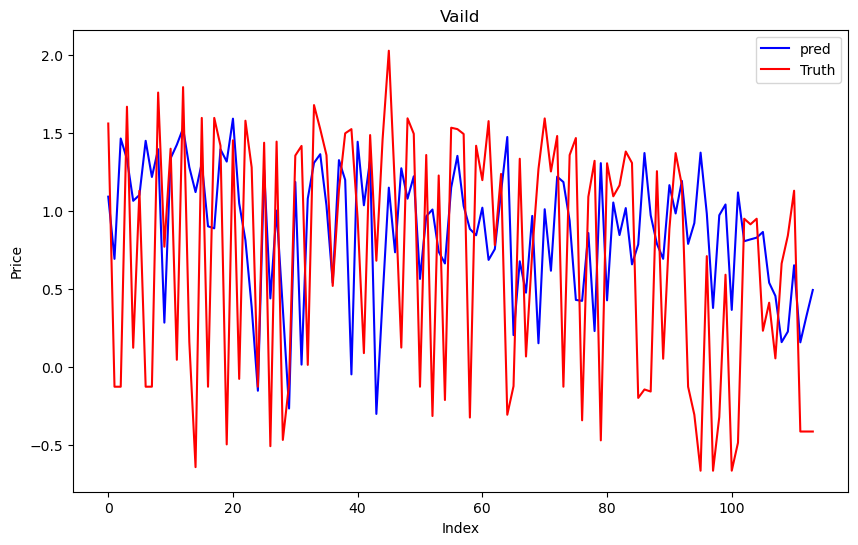

15/15 [==============================] - 0s 3ms/step
The R2 score on the Train set is:	0.992
The R2 score on the Test set is:	-0.152
15/15 [==============================] - 0s 3ms/step


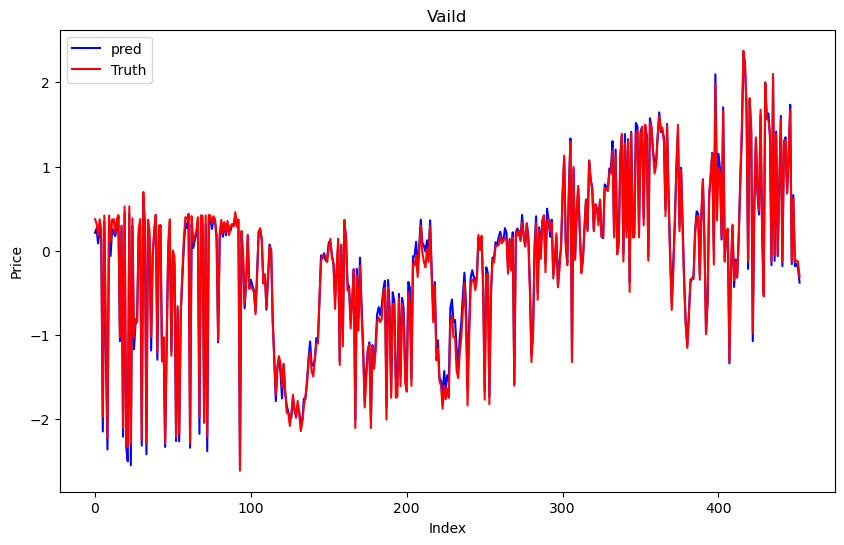

array([[ 2.13935316e-01],
       [ 2.59685963e-01],
       [ 8.82728994e-02],
       [ 2.66866297e-01],
       [ 1.42798483e-01],
       [-2.14521098e+00],
       [ 3.48532289e-01],
       [-1.26095319e+00],
       [-2.35803914e+00],
       [ 3.76886368e-01],
       [-6.16454519e-02],
       [ 2.62357265e-01],
       [ 2.09601119e-01],
       [ 1.74659193e-01],
       [ 2.75484592e-01],
       [ 4.09267336e-01],
       [-1.07260323e+00],
       [ 2.88573831e-01],
       [-2.20647621e+00],
       [ 4.59866256e-01],
       [-2.32071161e+00],
       [-2.49849916e+00],
       [ 4.33751732e-01],
       [-2.54492784e+00],
       [ 2.93975979e-01],
       [-1.17031169e+00],
       [-8.67225111e-01],
       [-8.24889183e-01],
       [ 1.83100075e-01],
       [ 3.11023533e-01],
       [-2.31235242e+00],
       [ 5.63426614e-01],
       [ 3.24811578e-01],
       [-2.41590571e+00],
       [ 3.51230443e-01],
       [ 1.14014395e-01],
       [-1.18374646e+00],
       [-6.62336200e-02],
       [ 2.0

In [109]:
def pred_plt(test_X, test_y):
    score(test_x, train_x)
    pred_x = LSTM_model.predict(test_X)
    plt.figure(figsize=(10, 6))
    plt.plot(pred_x, label='pred', color='blue')
    plt.plot(test_y, label='Truth', color='red')
    plt.legend()
    plt.title('Vaild')
    plt.xlabel('Index')
    plt.ylabel('Price')
    # plt.xlim(0, 30)
    plt.show()
    
    return pred_x

from sklearn.metrics import r2_score


def score(test, train):
    a= LSTM_model.predict(test)
    
    b = LSTM_model.predict(train)
    
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, b)))
    
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, a)))
    
    
pred_plt(test_x, test_y)
pred_plt(train_x, train_y)

15/15 [==============================] - 0s 4ms/step
The R2 score on the Train set is:	0.993
The R2 score on the Test set is:	-0.339
4/4 [==============================] - 0s 4ms/step


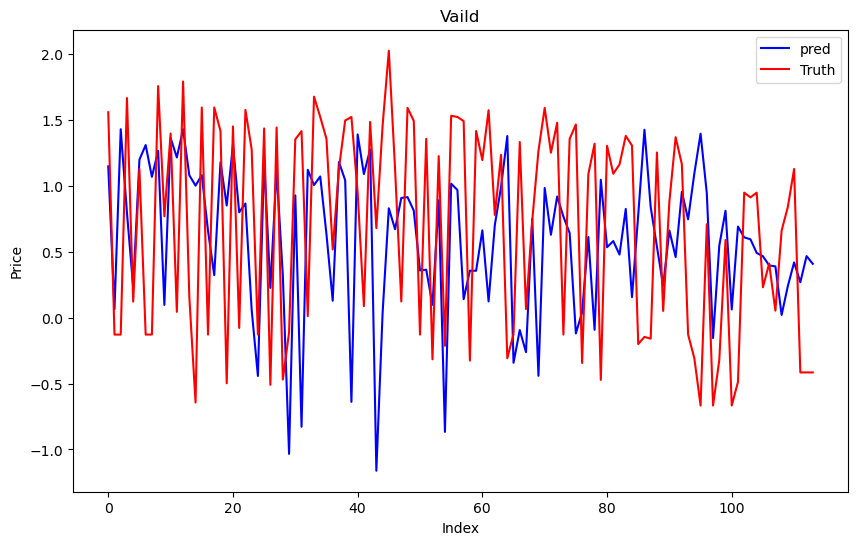

15/15 [==============================] - 0s 5ms/step
The R2 score on the Train set is:	0.993
The R2 score on the Test set is:	-0.339
15/15 [==============================] - 0s 4ms/step


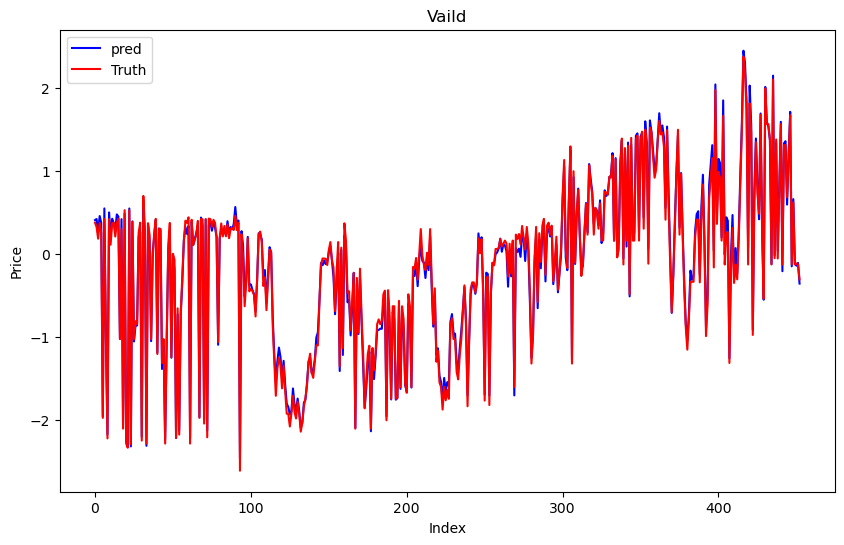

array([[ 4.06663299e-01],
       [ 4.18832481e-01],
       [ 2.66220659e-01],
       [ 4.54776615e-01],
       [ 3.71112794e-01],
       [-1.95596921e+00],
       [ 5.46551704e-01],
       [-9.87725675e-01],
       [-2.17378068e+00],
       [ 4.98831511e-01],
       [ 1.99538678e-01],
       [ 4.22273874e-01],
       [ 3.70592594e-01],
       [ 2.80282825e-01],
       [ 4.74695474e-01],
       [ 4.47272360e-01],
       [-1.02483761e+00],
       [ 4.17257398e-01],
       [-2.05566502e+00],
       [ 4.83548850e-01],
       [-2.25953269e+00],
       [-2.31265759e+00],
       [ 5.45975387e-01],
       [-2.31778407e+00],
       [ 3.90587986e-01],
       [-1.05523098e+00],
       [-8.63403976e-01],
       [-8.62452626e-01],
       [ 2.08800033e-01],
       [ 2.61941969e-01],
       [-2.20062876e+00],
       [ 5.82865417e-01],
       [ 2.28796229e-01],
       [-2.31042075e+00],
       [ 3.52100134e-01],
       [ 1.63286924e-01],
       [-1.05103183e+00],
       [ 7.76192546e-03],
       [ 2.2

In [116]:
def pred_plt(test_X, test_y):
    score(test_x, train_x)
    pred_x = best_model.predict(test_X)
    plt.figure(figsize=(10, 6))
    plt.plot(pred_x, label='pred', color='blue')
    plt.plot(test_y, label='Truth', color='red')
    plt.legend()
    plt.title('Vaild')
    plt.xlabel('Index')
    plt.ylabel('Price')
    # plt.xlim(0, 30)
    plt.show()
    
    return pred_x

from sklearn.metrics import r2_score


def score(test, train):
    a= best_model.predict(test)
    
    b = best_model.predict(train)
    
    print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(train_y, b)))
    
    print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(test_y, a)))
    
    
pred_plt(test_x, test_y)
pred_plt(train_x, train_y)